# Welcome to ProgPy's Horizon Example Notebook! 

This example performs a state estimation and prediction with uncertainty given a Prognostics Model with a specific prediction horizon. This prediction horizon marks the end of the "time of interest" for the prediction. Often this represents the end of a mission or sufficiently in the future where the user is unconcerned with the events that occur after this time.

__Method: An instance of the [ThrownObject](https://nasa.github.io/progpy/api_ref/prog_models/IncludedModels.html#thrownobject) model in ProgPy is created, and the prediction process is achieved in two steps:__
1) State estimation of the current state is performed using a chosen state_estimator, and samples are drawn from this estimate
2) Prediction of future states (with uncertainty) and the times at which the event thresholds will be reached, within the prediction horizon. All events outside the horizon come back as None and are ignored in metrics

__Results:__
- Predicted future values (inputs, states, outputs, event_states) with uncertainty from prediction
- Time event is predicted to occur (with uncertainty)

Here's a high level overview on how ProgAlgs work:

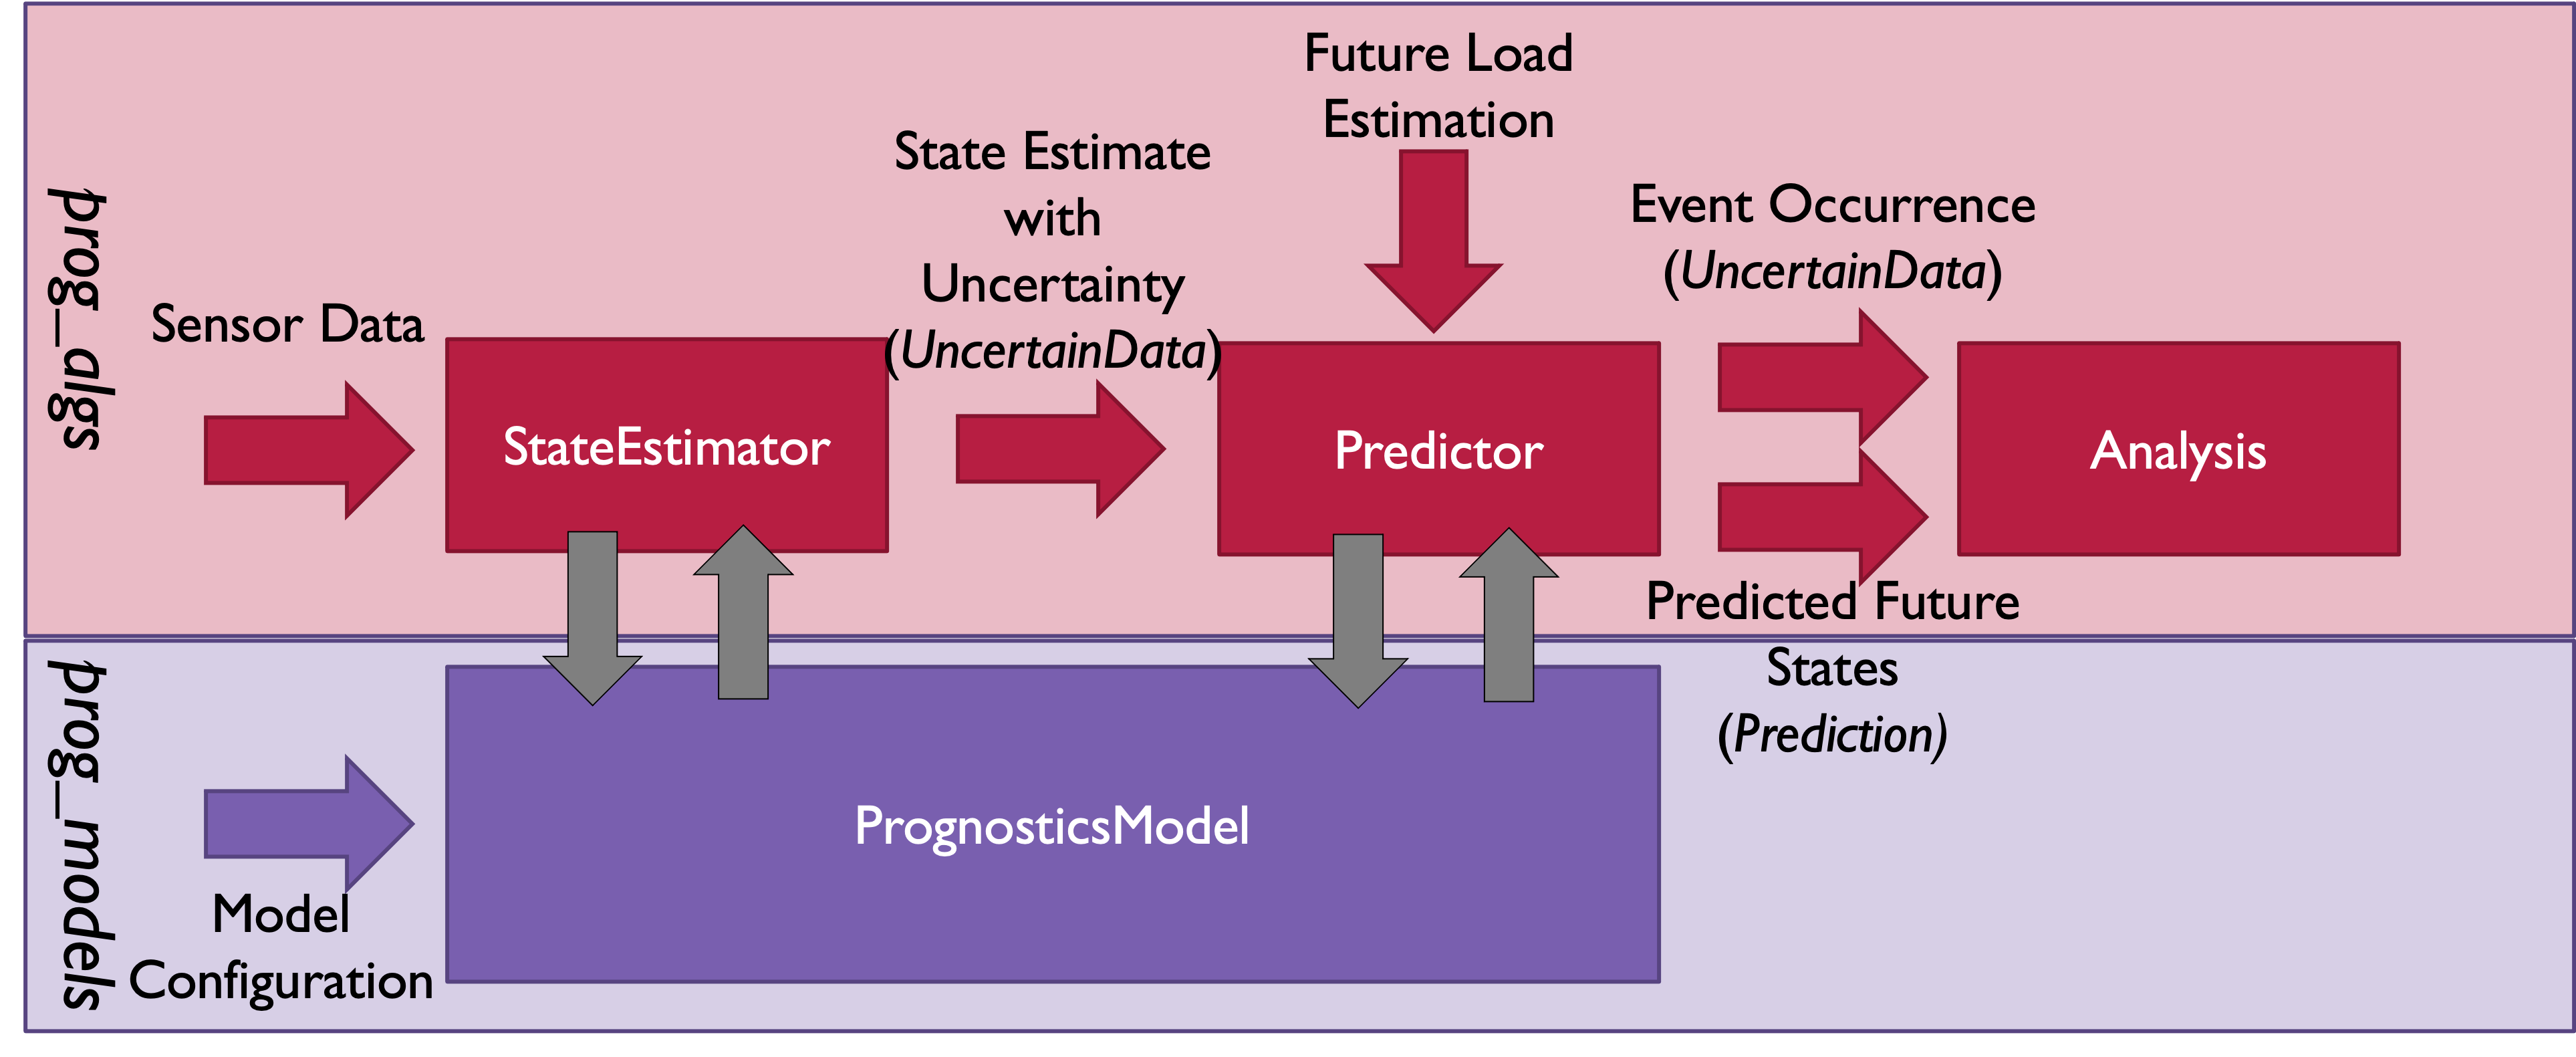

### Importing Modules

In [ ]:
from progpy.models.thrown_object import ThrownObject
from progpy import *
from pprint import pprint

First, let's define our model! We'll define a `ThrownObject` model with `process_noise` and `measurement_noise` set to 0.25 and 0.2 respectively.

In [ ]:
m = ThrownObject(process_noise = 0.25, measurement_noise = 0.2)

To perform state estimation of the current state, we'll utilize the `ParticleFilter` state estimator. Before we call state estimator, we'll need to pass the current state and the number of particles to the estimator. We'll set the number of particles to 1000.

In [ ]:
initial_state = m.initialize()
NUM_SAMPLES = 1000

# Pass the initial state and number of samples to our particle filter
filt = state_estimators.ParticleFilter(m, initial_state, num_particles = NUM_SAMPLES)

Let's estimate what our `filt` object looks like in one step:

In [ ]:
u = m.InputContainer({})  # No input for ThrownObject
filt.estimate(0.1, u, m.output(initial_state))

__Note__: In a prognostic application the above state estimation step would be repeated each time there is new data. Here we're doing one step to demonstrate how the state estimator is used.

Let's demonstrate the predictor. We'll first need to setup the predictor. In our example, we'll be using the [MonteCarlo](https://nasa.github.io/progpy/prog_algs_guide.html#prog_algs.predictors.MonteCarlo) Predictor!

In [ ]:
mc = predictors.MonteCarlo(m)

Now, let's perform a prediction. Here we set a prediction horizon of 7.75 seconds. We're saying that we are not interested in any events that occur after this time.

Furthermore, since we're using a particle filter, which is also sample-based, we can use the same samples from the `filt` object without changes.

Finally, the predict function requires a future loading function to be passed. This function is used to generate future inputs to the model. Since our model does not have any inputs, we'll pass a function that returns an empty set.

In [ ]:
PREDICTION_HORIZON = 5
samples = filt.x
STEP_SIZE = 0.001

def future_loading(t, x = None):
    return {}

# Making Prediction
mc_results = mc.predict(samples, future_loading, dt=STEP_SIZE, horizon = PREDICTION_HORIZON)


#### Let's see the results of the predicted time of event!

In [ ]:
metrics = mc_results.time_of_event.metrics()
print("\nPredicted Time of Event:")
print("\nSamples where impact occurs before horizon: {:.2f}%".format(metrics['impact']['number of samples']/100 * 100))
pprint(metrics)  # Note this takes some time
mc_results.time_of_event.plot_hist(keys = 'impact')
mc_results.time_of_event.plot_hist(keys = 'falling')

As you can see from the results...

To conclude...